# 2020 Presidential Election Time Series
## Project Setup

In [1]:
import os
from git import Repo
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import time
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bokeh.plotting import figure, output_file, show #, save
from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool, NumeralTickFormatter, Range1d
from bokeh.io import output_notebook, reset_output, save  # export_png 

### Set Variables for timezone info, HTML tags, and Data

In [2]:
# Add Election Project as remote source on Repo, remote:https://github.com/ElectProject/Early-Vote-2020G.git
repo_path = '.\Early-Vote-2020G'
cloned_repo = Repo(path=repo_path)
# Add html path containing data
html_path = 'docs/index.html'
# Tags for sparsing HTML data
date_slice_start, date_slice_end = len('Last updated: '),-len(' Eastern Time')
timezone = pytz.timezone('US/Eastern')
topline_ids = ['total-mail-ballots-returned-or-in-person-early-votes', 'mail-ballots-requested']
table_ids = ['voted-mail-ballots-by-party-registration', 'mail-ballots-requested-by-party-registration']
cast_str = [re.compile(r'Voters have cast a total of'), re.compile(r'Total Early Votes: ')]
request_str = [re.compile(r'Voters have requested a total of'), re.compile(r'There are a total of ')]
# DataFrame empty list initialization and columns names

totals_pkl_file = '2020_vote_totals.pkl'

# http://www.electproject.org/early_2016
# 09/25/16 https://www.huffpost.com/entry/2016-early-voting-underwa_b_12184290 9,525 
# 10/02/16 https://www.huffpost.com/entry/early-in-the-early-voting_b_12303146 74,836
# 10/09/16 https://www.huffpost.com/entry/early-voting-a-month-to-g_b_12424562 429,337
# 10/16/16 https://www.huffpost.com/entry/early-voting-more-states_b_12517738 1,400,000
# 10/23/16 https://www.huffpost.com/entry/early-voting-the-election_b_12614284 5,900,000
# 10/30/16 https://www.huffpost.com/entry/early-voting-stability-de_b_12723188 21,000,000
# 11/02/16 https://docs.google.com/spreadsheets/d/1fz_V3oAUL8XJMEudq5wm5hDT_f554uagt6sIm_sJDro/edit?usp=sharing 46,220,922
# 11/03/16 https://docs.google.com/spreadsheets/d/1fz_V3oAUL8XJMEudq5wm5hDT_f554uagt6sIm_sJDro/edit?usp=sharing total votes without write-ins 128,925,332
# 11/03/16 https://ballotpedia.org/Presidential_election,_2016 136,452,15

vote_2016_dict = {'datetime':
                  ['09/25/2016 10:59 PM', '10/02/2016 10:59 PM', '10/09/2016 10:59 PM', '10/16/2016 10:59 PM', '10/23/2016 10:59 PM', '10/30/2016 10:59 PM', '11/02/2016 10:59 PM', '11/03/2016 10:59 PM'], 
                  'vote_total_2016':
                  [9525 , 74836, 429337, 1400000, 5900000, 21000000, 46220922, 136452150]}

In [3]:
print('Repo: \'{}\': {}\nTotal commits: {}\n{} commits: {}'.format(cloned_repo.remotes.origin.name, 
                                                                   cloned_repo.remotes.origin.url, 
                                                                   len(list(cloned_repo.iter_commits('master'))), 
                                                                   html_path, 
                                                                   len(list(cloned_repo.iter_commits('master', paths=html_path)))
                                                                  ))

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1135
docs/index.html commits: 492


### Functions for Retrieving and Plotting 2020 Vote Data

In [4]:
def get_commits(repo):
    repo.remotes.origin.fetch()
    # cloned_repo.heads.master.tracking_branch()
    repo.remotes.origin.pull()
    commits_list = list(cloned_repo.iter_commits('master', paths=html_path))
    return commits_list

In [5]:
def totals_init(data_file=''):
    totals_list = []
    totals_cols = ['commit','datetime','vote_id','vote_total', 'request_id', 'request_total']
    if data_file[-4:]=='.pkl':
        try:
            df = pd.read_pickle(pkl_file)
        except:
            df = pd.DataFrame(totals_list,columns=totals_cols)
    else:
        df = pd.DataFrame(totals_list,columns=totals_cols)
    return df

In [6]:
def get_data(repo, pkl_file, pkl_save=None):
    commits = get_commits(repo)
    df = totals_init(pkl_file)
    for c in commits:
        if c.hexsha not in df['commit']:
            soup = BeautifulSoup(c.tree[html_path].data_stream.read(), 'html.parser')
            file_datetime = soup.find(text=re.compile(r'Last updated: '))[date_slice_start:date_slice_end]
            pd_datetime = timezone.localize(datetime.strptime(file_datetime, '%m/%d/%Y %I:%M %p'))

            t_dict = None
            total_cast = None
            cast_idx = None
            cast_tag_id = None
            total_request = None
            request_tag_id = None
            req_str = None
        
#             print('hash: {}\npath: {}\ndatetime: {}'.format(c.hexsha, c.tree[html_path].path, file_datetime))

            try:
                total_cast = int(soup.find(text=cast_str[0]).parent.strong.text.replace(',', ''))
                cast_idx = 0
            except:
                try:
                    total_cast = int(soup.find(text=cast_str[1]).parent.strong.text.replace(',', ''))
                    cast_idx = 1
                except:
                    total_cast = np.nan

            if total_cast != np.nan:
                try:
                     cast_tag_id = soup.find(text=cast_str[cast_idx]).parent.parent['id']
                except:
                    cast_tag_id = np.nan
            else:
                cast_tag_id = np.nan


            try:
                total_request = int(soup.find(text=request_str[0]).parent.strong.text.replace(',', ''))
                req_str = request_str[0]
            except:
                try:
                    total_request = int(soup.find(text=request_str[1]).parent.strong.text.replace(',', ''))
                    req_str=request_str[1]
                except:
                    total_request = np.nan

            if total_request != np.nan and req_str != None:
                try:
                    request_tag_id = soup.find(text=req_str).parent.parent['id']
                except:
                    request_tag_id = np.nan
            else:
                request_tag_id = np.nan

            t_dict = {'commit':c.hexsha,'datetime':pd_datetime,'vote_id':cast_tag_id,'vote_total':total_cast, 'request_id':request_tag_id, 'request_total':total_request}
            df = df.append(t_dict, ignore_index=True)
            
    if pkl_save[-4:]=='.pkl':
        df.to_pickle(pkl_save)
    return df

In [7]:
def get_2016_data(vote_dict):
    df = pd.DataFrame.from_dict(vote_dict)
    df['datetime'] = df['datetime'].apply(lambda x: timezone.localize(datetime.strptime(x, '%m/%d/%Y %I:%M %p'))) + pd.DateOffset(years=4)
    return df

In [8]:
def vote2020plt(dates, values, dates_2016, values_2016):
    tstmp_sfrmt = '%m/%d/%Y %I:%M %p'
    elec_2020_tstmp = '11/03/2020 11:59 PM'
    elec_date = timezone.localize(datetime.strptime(elec_2020_tstmp, tstmp_sfrmt))
    elec_start_dt = dates.min()

    xlim = (elec_date + timedelta(days=4)).date()
    ylim=int(180*1e6)

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.plot(dates, values, 'o-', label='2020 votes cast')
    ax.plot(dates_2016, values_2016, 'ro-', label='2016 votes cast')

    plt.title('2020 Early Voting Time Series', size='x-large')
    plt.xlabel('Date', size='x-large')
    plt.ylabel('Votes Cast (Millions)', size='xx-large')
    ax.legend(fontsize='xx-large')
    ax.grid(True)

    # https://matplotlib.org/3.3.1/gallery/ticks_and_spines/tick-formatters.html
    # see also millify https://github.com/azaitsev/millify

    ax.set_xlim(right=xlim)
    ax.set_ylim(top=ylim)

    ax.yaxis.set_major_formatter(lambda x, pos: '{:1.1f}M'.format(x*1e-6)) 
    ax.set_xticks(list(ax.get_xticks()) + [mdates.date2num(elec_date)])
    # plt.setp(ax.get_xticklabels()[-1], x=elec_date, y=0, text=elec_date.strftime('%Y-%m-%d'))

    ax.axvline(x=elec_date, color='#1f77b4')
    ax.axhline(y=max(values_2016), ls='--', color='red')
    # ax.plot(level_2016, [max(values_2016),max(values_2016)], "--", color="r", markerfacecolor="w")

    level_2016=[ax.get_xticks()[4],mdates.date2num(max(dates_2016))]
    ax.annotate('2016 vote: {:1.1f}M'.format(max(values_2016)*1e-6),(level_2016[0],max(values_2016)+.5e7),size='xx-large')
    ax.annotate('2020 vote: {:1.1f}M'.format(max(values)*1e-6),(mdates.date2num(max(dates)),max(values)+.5e7),size='xx-large')

    plt.text(x=(elec_date-timedelta(days=4)), y=14*1e7, s='Election', rotation=30, color='#1f77b4', size='xx-large')
    fig.autofmt_xdate()

    fig.savefig('2020_vs_2016_votes.png')
    fig.savefig('2020_vs_2016_votes.jpg')

    plt.show()

In [9]:
def vote2020_bokeh(df2020, df2016):
    reset_output()

    html_file = '2020_v_2016_votes_cast.html'
    netlify_html = './netlify/index.html'

    p = figure(plot_height=250, x_axis_type="datetime", tools="", toolbar_location=None,
               title="2020 Votes Cast", sizing_mode="scale_width", y_range=Range1d(int(-8*1e5),int(18*1e7)))

    p.background_fill_color="#f5f5f5"
    p.grid.grid_line_color="white"
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Votes'
    p.axis.axis_line_color = None

    data_date_max = ColumnDataSource(data={
        'max_date' : df2020.groupby(by=[df2020.datetime.dt.date]).vote_total.max().index,
        'vote_date_total' : df2020.groupby(by=[df2020.datetime.dt.date]).vote_total.max()
    })

    # v2020 = p.line(x='datetime', y='vote_total', line_width=2, color='#ebbd5b', source=df_totals)
    v2020 = p.line(x='max_date', y='vote_date_total', line_width=2, source=data_date_max)
    v2016 = p.line(x='datetime', y='vote_total_2016', line_width=2, color='red', source=df2016)

    # custom_filter = CustomJSFilter(code='''
    # var indices = [];

    # // iterate through rows of data source and see if each satisfies some constraint
    # for (var i = 0; i < source.get_length(); i++){
    #     if (source.data['datetime'][i] == 'some_value'){
    #         indices.push(true);
    #     } else {
    #         indices.push(false);
    #     }
    # }
    # return indices;
    # ''')

    hover_2020 = HoverTool(renderers=[v2020],
        tooltips=[
            ( 'date',   '@max_date{%m/%d/%Y}'            ), # {%F}
    #         ( '2016 votes',  '@vote_total_2016{0.0a}' ), # {:1.1f}M
            ( '2020 votes', '@vote_date_total{0.0a}'      ) # {:1.1f}M {0.0a} @vote_date_total
    #         ( '2020 votes', '@vote_total{:1.1f}M'      ),
        ],
        line_policy='nearest',
        formatters={
            '@max_date'        : 'datetime', # use 'datetime' formatter for '@date' field
    #         '@2016 votes' : 'numeral',   # use 'printf' formatter for '@{adj close}' field
            '@vote_date_total' : 'numeral' # use default 'numeral' formatter for other fields
    #         '@2020 votes' : 'printf' # use default 'numeral' formatter for other fields
        },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline', # 'mouse'
        attachment='above'
    #     anchor='top_center'
    )

    hover_2016 = HoverTool(renderers=[v2016],
        tooltips=[
            ( 'date',   '@datetime{%m/%d/%Y}'            ), # {%F}
            ( '2016 votes',  '@vote_total_2016{0.0a}' ), # {:1.1f}M
    #         ( '2020 votes', '@vote_date_total{0.0a}'      ) # {:1.1f}M {0.0a} @vote_date_total
    #         ( '2020 votes', '@vote_total{:1.1f}M'      ),
        ],
        line_policy='nearest',
        formatters={
            '@datetime'        : 'datetime', # use 'datetime' formatter for '@date' field
            '@2016 votes' : 'numeral',   # use 'printf' formatter for '@{adj close}' field
    #         '@vote_date_total' : 'numeral' # use default 'numeral' formatter for other fields
    #         '@2020 votes' : 'printf' # use default 'numeral' formatter for other fields
        },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline', # 'mouse',
    #     anchor='bottom_center',
    #     point_policy='snap_to_data'
        attachment='below'
    )

    cross = CrosshairTool(dimensions='height')
    p.yaxis.formatter=NumeralTickFormatter(format='0.0a')
    p.add_tools(hover_2020)
    p.add_tools(hover_2016)
    p.add_tools(cross)

    output_notebook()
    show(p)
    output_file(html_file)
    save(p, filename=html_file)
    reset_output()
    output_file(netlify_html)
    save(p, filename=netlify_html)
    reset_output()
    # export_png(p, filename="bokeh_2020_v_2016_votes.png")


In [10]:
def update_md(filename, replace_list):
    with open(filename,'r') as file:
        filetext = file.read()
        for k, v in replace_list.items():
            pattern = re.compile('(?<=<!--start '+k+'-->\n)([\S\s]+)(?=\n<!--end '+k+'-->)')
            filetext = filetext.replace(pattern.search(filetext).group(1), v)
    with open(filename,'w') as file:
        file.write(filetext)

### Fetch Data from Election Project

In [11]:
df_totals = get_data(cloned_repo, totals_pkl_file, totals_pkl_file)
df_totals

,commit,datetime,vote_id,vote_total,request_id,request_total
0,41f0382ff1390e0f7838e10b3809a00a5e9d604d,2020-10-19 13:35:00-04:00,total-voted,29147064,mail-ballots-requested,82521750
1,0df144a2187551af598880e194b7443fc9cfb70a,2020-10-27 13:36:00-04:00,total-voted,67113097,mail-ballots-requested,88320053
2,1dac676be6071a7444c724aae765bb96fda7eb6d,2020-10-27 12:43:00-04:00,total-voted,66942790,mail-ballots-requested,88266021
3,6738fc5620a89c0372bcd3f7ebd8d3bc141582b1,2020-10-27 11:49:00-04:00,total-voted,66754673,mail-ballots-requested,88193160
4,dc8f7de1cc8fe8b56cbeab49222bd8bdcc43d684,2020-10-27 11:02:00-04:00,total-voted,66666268,mail-ballots-requested,88191088
...,...,...,...,...,...,...
497,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
498,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
499,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
500,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


### Compile 2016 Data

In [12]:
df_2016_totals = get_2016_data(vote_2016_dict)
df_2016_totals

,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


### Plot of Total Votes Cast 2020 vs 2016

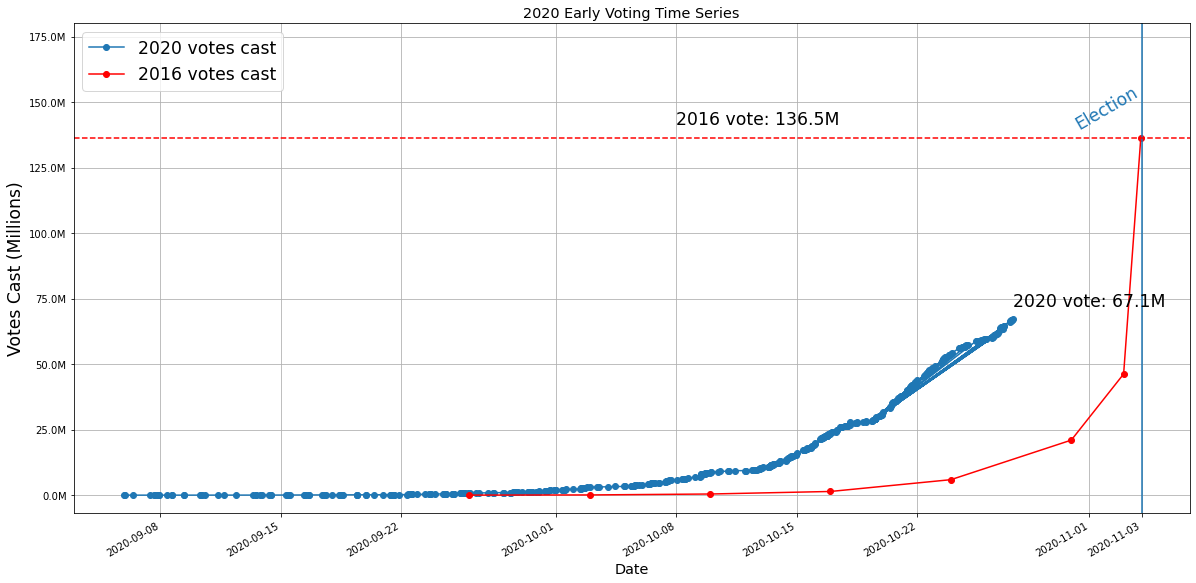

In [13]:
vote2020plt(df_totals['datetime'], df_totals['vote_total'], df_2016_totals['datetime'], df_2016_totals['vote_total_2016'])

### Interactive Plot Using Bokeh

In [14]:
vote2020_bokeh(df_totals, df_2016_totals)

Loading BokehJS ...

In [15]:
rdme_fname = 'Readme.md'
rpl_text = {'table_2016':df_2016_totals.groupby(by=[df_2016_totals.datetime.dt.date]).vote_total_2016.max().apply('{:,.0f}'.format).to_markdown(),
            'table_2020':df_totals.groupby(by=[df_totals.datetime.dt.date]).vote_total.max().apply('{:,.0f}'.format).to_markdown()}

In [16]:
update_md(rdme_fname, rpl_text)